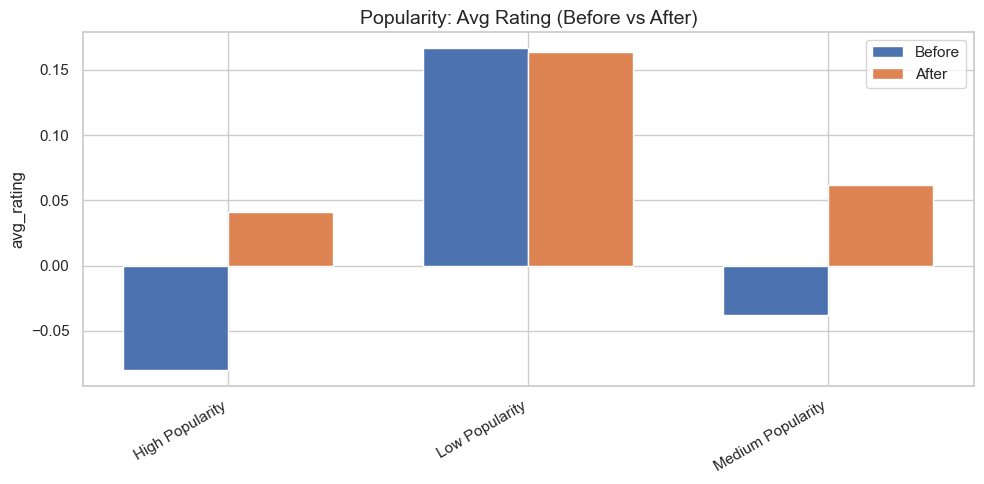

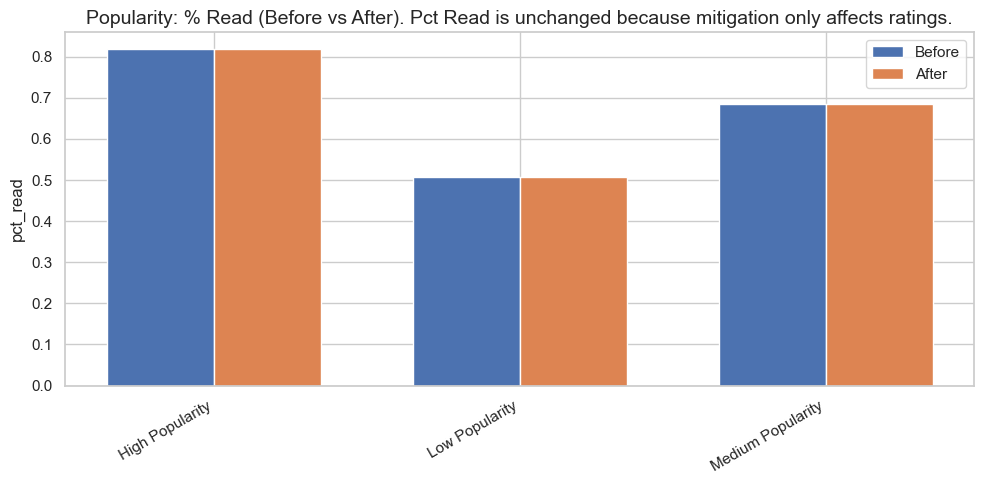

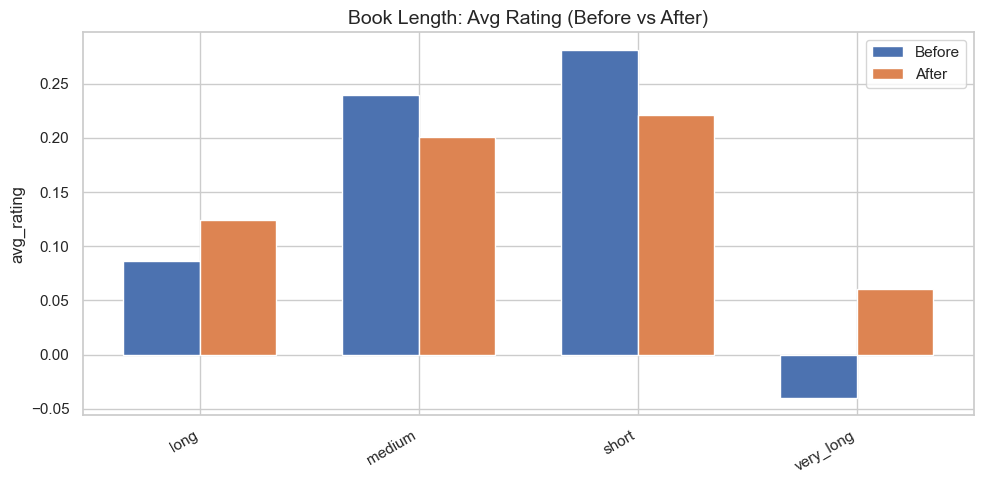

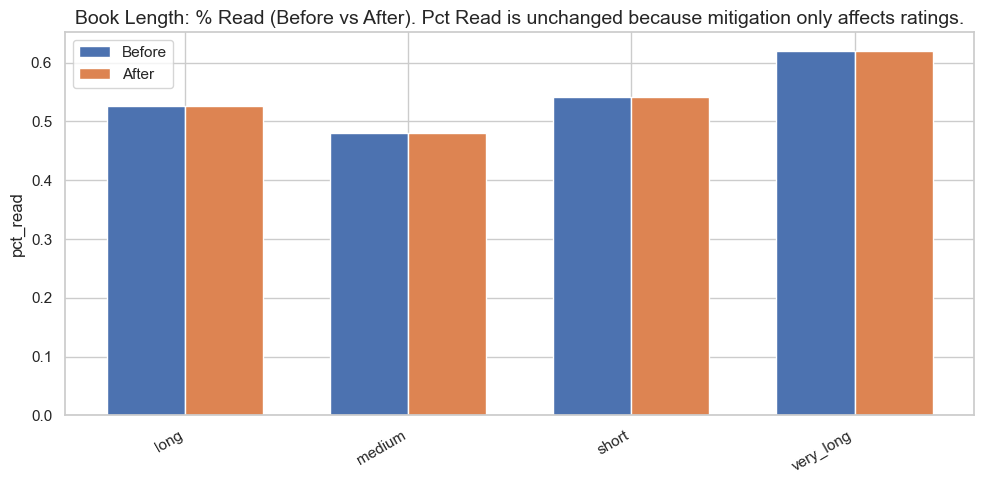

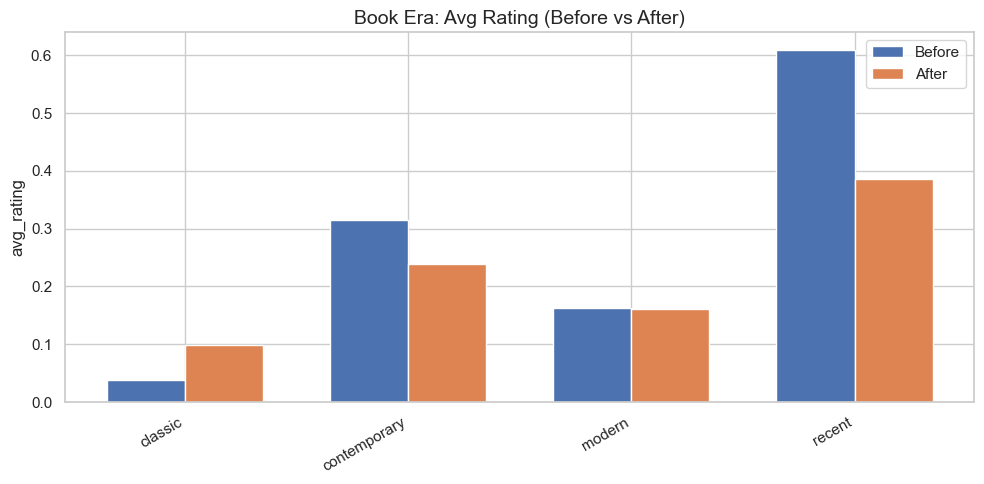

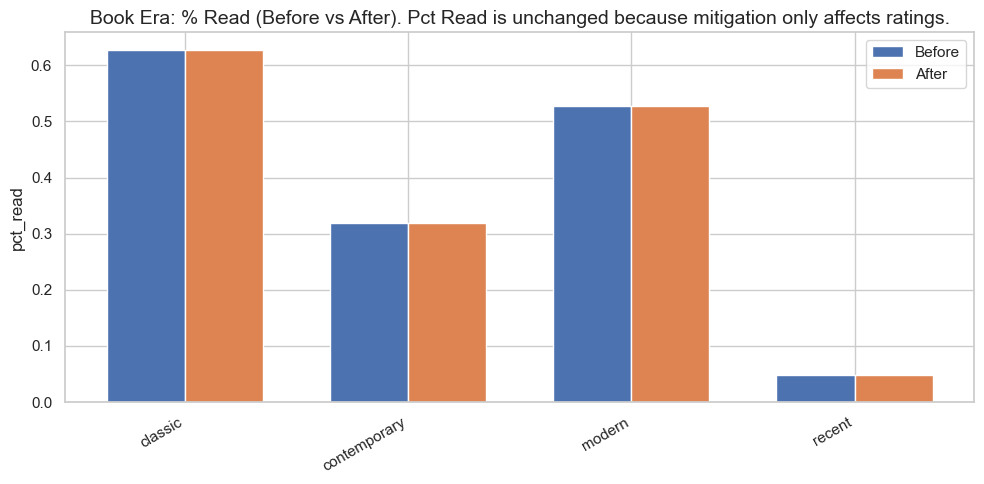

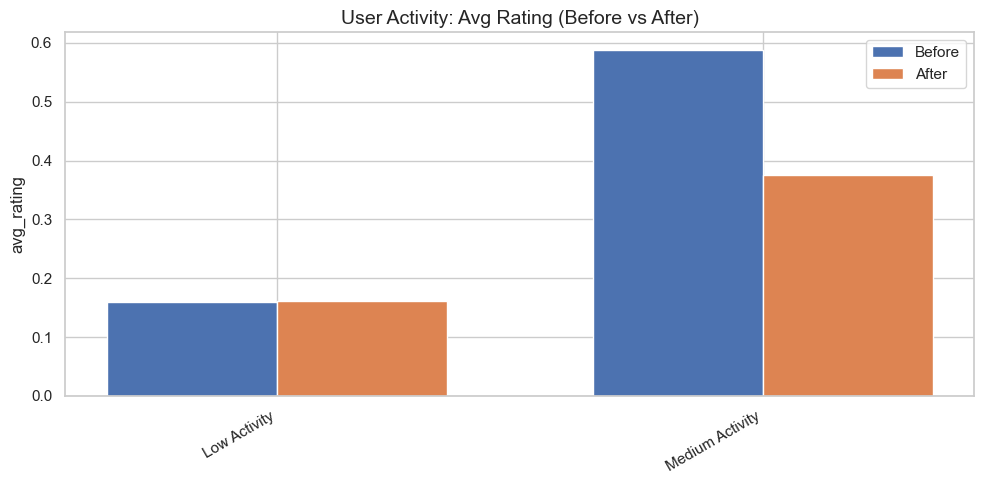

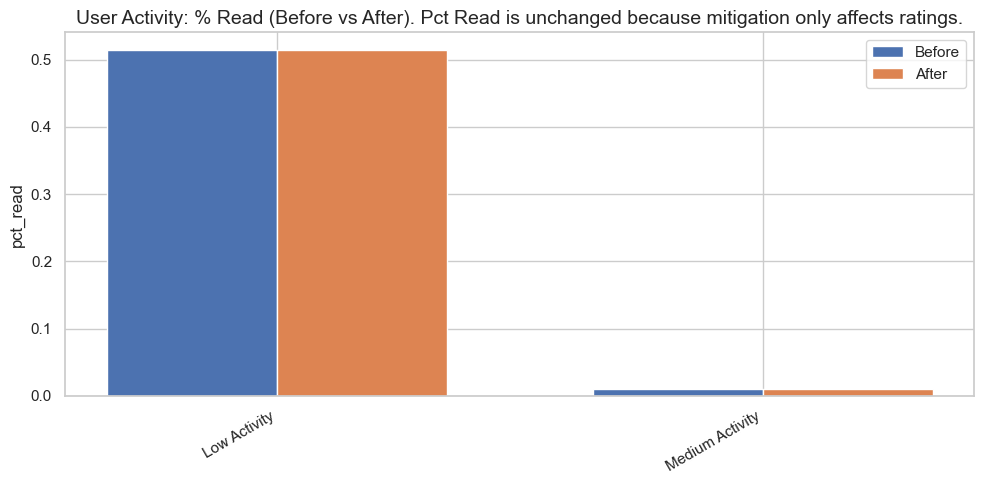

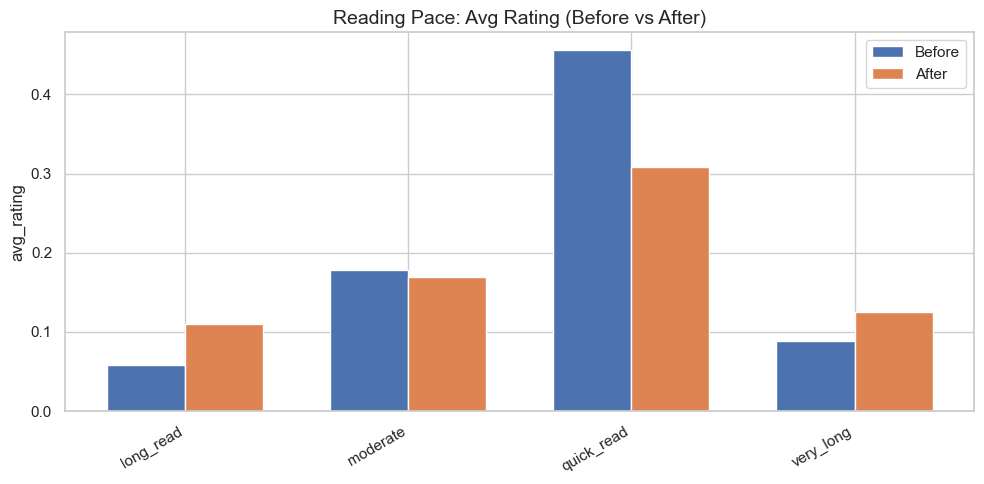

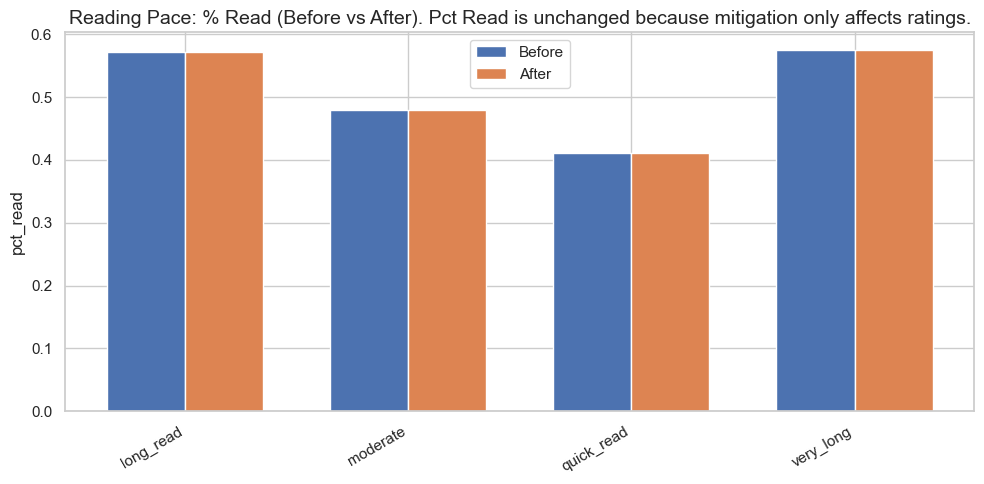

,dimension,variance_before,variance_after,mean_before,mean_after,relative_mean_change,variance_ratio,equity_index
0,Popularity,0.011568,0.002892,0.016339,0.088830,4.436547,0.25,0.209530
1,Book Length,0.016265,0.004066,0.141909,0.151615,0.068395,0.25,0.675332
2,Book Era,0.045612,0.011403,0.280916,0.221118,-0.212867,0.25,0.603096
3,User Activity,0.045814,0.011453,0.374450,0.267885,-0.284590,0.25,0.567235
4,Reading Pace,0.024497,0.006124,0.195336,0.178328,-0.087069,0.25,0.665996


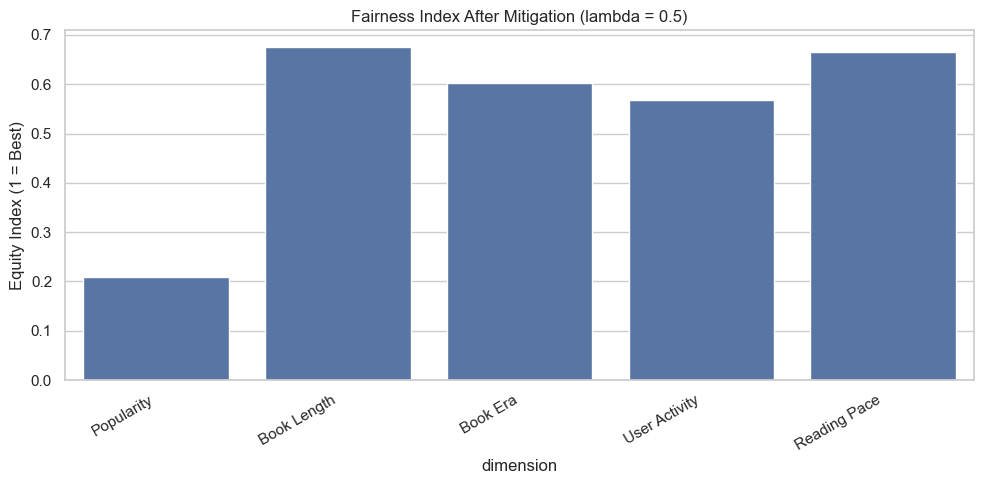

Saved fairness summary to fairness_summary_lambda_0_5.csv


In [ ]:
import os
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

# ------------- CONFIG -------------
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "gcp_credentials.json"
project_id = "recommendation-system-475301"
dataset = "books"
table = "goodreads_features_cleaned"
BQ_TABLE = f"`{project_id}.{dataset}.{table}`"

client = bigquery.Client(project=project_id)
sns.set(style="whitegrid")

# Shrinkage parameter
LAMBDA = 0.5  # medium correction

# ------------- HELPERS -------------
def plot_before_after_side_by_side(before_df, after_df, label_col, value_col, title):
    merged = before_df.merge(after_df, on=label_col, suffixes=('_before', '_after'))
    labels = merged[label_col].astype(str).tolist()
    before_vals = merged[f"{value_col}_before"].tolist()
    after_vals = merged[f"{value_col}_after"].tolist()

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - width/2, before_vals, width, label='Before')
    ax.bar(x + width/2, after_vals, width, label='After')
    ax.set_ylabel(value_col)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

def fairness_metrics(before_df, after_df, value_col, group_col):
    merged = before_df.merge(after_df, on=group_col, suffixes=("_before", "_after"))

    var_before = merged[f"{value_col}_before"].var(ddof=0)
    var_after = merged[f"{value_col}_after"].var(ddof=0)
    mean_before = merged[f"{value_col}_before"].mean()
    mean_after = merged[f"{value_col}_after"].mean()

    eps = 1e-9
    rel_mean_change = (mean_after - mean_before) / (abs(mean_before) + eps)
    variance_ratio = var_after / (var_before + eps)

    mean_penalty = min(1.0, abs(rel_mean_change))
    if variance_ratio <= 0:
        var_penalty = 1.0
    else:
        var_penalty = 1.0 - 1.0 / (1.0 + abs(np.log(variance_ratio + eps)))

    equity_index = max(0.0, 1.0 - 0.5 * mean_penalty - 0.5 * var_penalty)

    return {
        "variance_before": float(var_before),
        "variance_after": float(var_after),
        "mean_before": float(mean_before),
        "mean_after": float(mean_after),
        "relative_mean_change": float(rel_mean_change),
        "variance_ratio": float(variance_ratio),
        "equity_index": float(equity_index),
    }

def run_grouped_analysis(dimension_name, group_case_sql, label_col):
    query_before = f"""
    SELECT
      {group_case_sql} AS {label_col},
      AVG(user_avg_rating_vs_book) AS avg_rating,
      AVG(CASE WHEN is_read THEN 1 ELSE 0 END) AS pct_read
    FROM {BQ_TABLE}
    GROUP BY 1
    ORDER BY 1
    """
    before_df = client.query(query_before).to_dataframe()

    query_after = f"""
    WITH base AS (
      SELECT *, {group_case_sql} AS {label_col}
      FROM {BQ_TABLE}
    ),
    group_stats AS (
      SELECT {label_col}, AVG(user_avg_rating_vs_book) AS group_mean
      FROM base
      GROUP BY {label_col}
    ),
    global AS (
      SELECT AVG(user_avg_rating_vs_book) AS global_mean FROM base
    ),
    adjusted AS (
      SELECT
        b.*,
        g.group_mean,
        (b.user_avg_rating_vs_book - {LAMBDA} * (g.group_mean - (SELECT global_mean FROM global)))
          AS rating_debiased
      FROM base b
      JOIN group_stats g ON b.{label_col} = g.{label_col}
    )
    SELECT
      {label_col},
      AVG(rating_debiased) AS avg_rating,
      AVG(CASE WHEN is_read THEN 1 ELSE 0 END) AS pct_read
    FROM adjusted
    GROUP BY 1
    ORDER BY 1
    """
    after_df = client.query(query_after).to_dataframe()

    fairness = fairness_metrics(before_df, after_df, "avg_rating", label_col)
    return before_df, after_df, fairness

# ------------- RUN DIMENSIONS -------------
fairness_results = []

dimensions = [
    ("Popularity", """
        CASE
          WHEN book_popularity_normalized >= 0.66 THEN 'High Popularity'
          WHEN book_popularity_normalized >= 0.33 THEN 'Medium Popularity'
          ELSE 'Low Popularity'
        END""", "popularity_group"),

    ("Book Length", "book_length_category", "book_length_group"),
    ("Book Era", "book_era", "book_era_group"),

    ("User Activity", """
        CASE
          WHEN user_activity_count >= 50 THEN 'High Activity'
          WHEN user_activity_count >= 10 THEN 'Medium Activity'
          ELSE 'Low Activity'
        END""", "user_activity_group"),

    ("Reading Pace", "reading_pace_category", "reading_pace_group"),
]

for dim_name, case_sql, label_col in dimensions:
    before_df, after_df, fairness = run_grouped_analysis(dim_name, case_sql, label_col)
    fairness_results.append({"dimension": dim_name, **fairness})

    # --- Plot avg_rating ---
    plot_before_after_side_by_side(before_df, after_df, label_col, "avg_rating",
        f"{dim_name}: Avg Rating (Before vs After)")

    # --- Plot pct_read ---
    plot_before_after_side_by_side(before_df, after_df, label_col, "pct_read",
        f"{dim_name}: % Read (Before vs After). Pct Read is unchanged because mitigation only affects ratings.")

# ------------- FAIRNESS SUMMARY -------------
fairness_summary = pd.DataFrame(fairness_results)
display(fairness_summary)

plt.figure(figsize=(10, 5))
sns.barplot(x="dimension", y="equity_index", data=fairness_summary)
plt.title("Fairness Index After Mitigation (lambda = 0.5)")
plt.ylabel("Equity Index (1 = Best)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

fairness_summary.to_csv("fairness_summary_lambda_0_5.csv", index=False)
print("Saved fairness summary to fairness_summary_lambda_0_5.csv")
